In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [49]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

hidden_layer_sizes = [256, 256, 256, 256, 256, 256, 256, 256, 256, 256]

lr = 1e-4

# Normalization layers - SELU

In [50]:


class selu(nn.Module):
    def __init__(self, affine=False):
        super(selu, self).__init__()
        if affine:
            self.alpha = nn.Parameter(torch.FloatTensor([1.6732632423543772848170429916717]))
            self.scale = nn.Parameter(torch.FloatTensor([1.0507009873554804934193349852946]))
        else:
            self.alpha = 1.6732632423543772848170429916717
            self.scale = 1.0507009873554804934193349852946
            
    def forward(self, x):
        return self.scale * (F.relu(x) + self.alpha * F.elu(- F.relu(-x)))

In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc_in = nn.Linear(3 * 32 * 32, hidden_layer_sizes[0])
        self.linears = nn.ModuleList([nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]) for i in range(len(hidden_layer_sizes) - 1)])
        self.fc_out = nn.Linear(hidden_layer_sizes[-1], 10)
        self.selu = selu()

    def forward(self, x):
        activations = []
        x = x.view(-1, 3 * 32 * 32)
        x = self.selu(self.fc_in(x))
        activations = np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1)
        for i, l in enumerate(self.linears):
            x = self.selu(l(x))
            activations = np.append(activations, np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1), axis=1)
        x = self.fc_out(x)
        return x, activations
    
model = Net()
print(model)

Net (
  (fc_in): Linear (3072 -> 256)
  (linears): ModuleList (
    (0): Linear (256 -> 256)
    (1): Linear (256 -> 256)
    (2): Linear (256 -> 256)
    (3): Linear (256 -> 256)
    (4): Linear (256 -> 256)
    (5): Linear (256 -> 256)
    (6): Linear (256 -> 256)
    (7): Linear (256 -> 256)
    (8): Linear (256 -> 256)
  )
  (fc_out): Linear (256 -> 10)
  (selu): selu (
  )
)


In [52]:
class ActivationFollower():
    
    train_activations = 0
    train_labels = 0
    test_activations = 0
    test_labels = 0
    
    def __init__(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def reset(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
    
    def test_add(self, x, y):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
            self.test_labels = np.append(self.test_labels, y, axis=0)
        else:
            self.test_activations = x
            self.test_labels = y
        
    def print_metrics(self):
        bins = np.arange(0, 1.1, 0.1)
        proba_activate_layer = []
        for i in range(len(hidden_layer_sizes)):
            proba_activate_layer += [np.where(self.train_activations[:,i] == -1., 0, 1).mean(0)]
            
        data = np.vstack(proba_activate_layer).T
        plt.figure(figsize=(20,10))
        plt.hist(data, bins, label=['Layer : {}'.format(i) for i in range(1, len(proba_activate_layer) + 1)])
        plt.legend()
        plt.title('Histogram of probability of activation')
        plt.show()
        # Here sample and compute histogram of distances.
        # Then Matrix with std of distances between classes.
        

In [53]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [54]:
if cuda:
    model.cuda()
    criterion.cuda()

In [55]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations, target.cpu().data.numpy())
        if batch_idx > 500:
            break
#     for batch_idx, (data, target) in enumerate(testloader):
#         if cuda:
#             data, target = data.cuda(), target.cuda()
#         data, target = Variable(data), Variable(target)
#         output, activations = model(data)
#         metrics.test_add(activations, target.cpu().data.numpy())
        
    metrics.print_metrics()
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

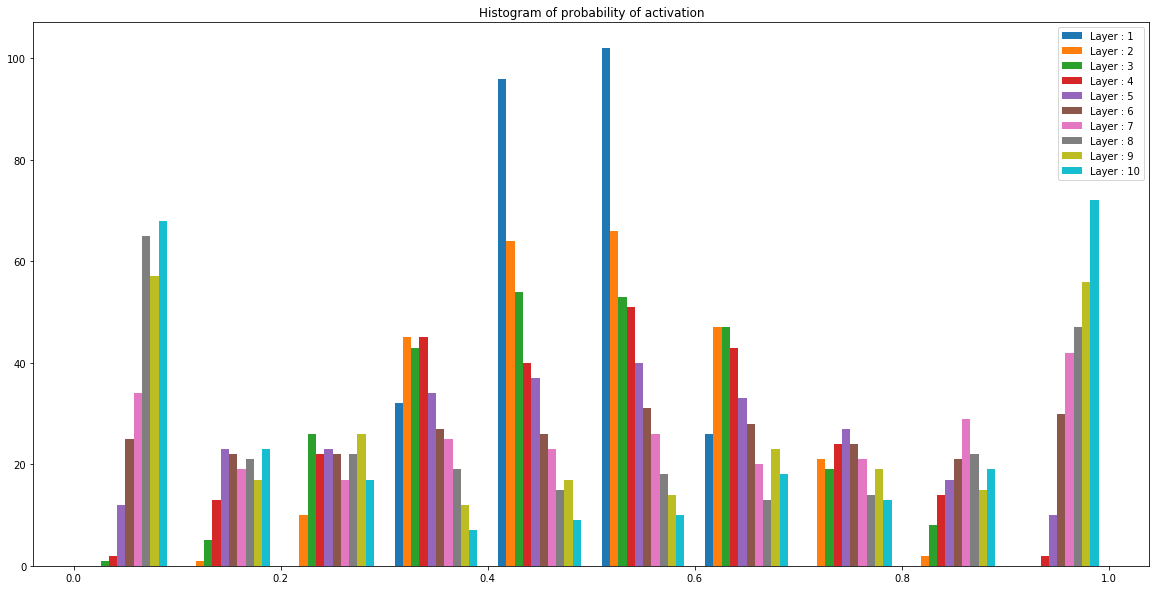

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.333218
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.271880
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.255208
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.264493
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.127623
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.162596
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.087556
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.776276

Test set: Average loss: 1.9627, Accuracy: 2750/10000 (28%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.782078
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.971387
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.118874
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.889185
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.985186
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.096293
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.644429
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.888899

Test set: Average loss: 1.8485, Accuracy: 3333/10000 (33%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.635358
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.757


Test set: Average loss: 1.4150, Accuracy: 4992/10000 (50%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 1.062052
Train Epoch: 19 [6400/50000 (13%)]	Loss: 1.030822
Train Epoch: 19 [12800/50000 (26%)]	Loss: 1.025918
Train Epoch: 19 [19200/50000 (38%)]	Loss: 1.364452
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.931824
Train Epoch: 19 [32000/50000 (64%)]	Loss: 1.648217
Train Epoch: 19 [38400/50000 (77%)]	Loss: 1.090444
Train Epoch: 19 [44800/50000 (90%)]	Loss: 1.288361

Test set: Average loss: 1.3995, Accuracy: 5086/10000 (51%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 1.542641
Train Epoch: 20 [6400/50000 (13%)]	Loss: 1.280080
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.910365
Train Epoch: 20 [19200/50000 (38%)]	Loss: 1.367245
Train Epoch: 20 [25600/50000 (51%)]	Loss: 1.640340
Train Epoch: 20 [32000/50000 (64%)]	Loss: 1.128937
Train Epoch: 20 [38400/50000 (77%)]	Loss: 1.063586
Train Epoch: 20 [44800/50000 (90%)]	Loss: 1.798938

Test set: Average loss: 1.4181, Accuracy: 4973/10000 (50%)



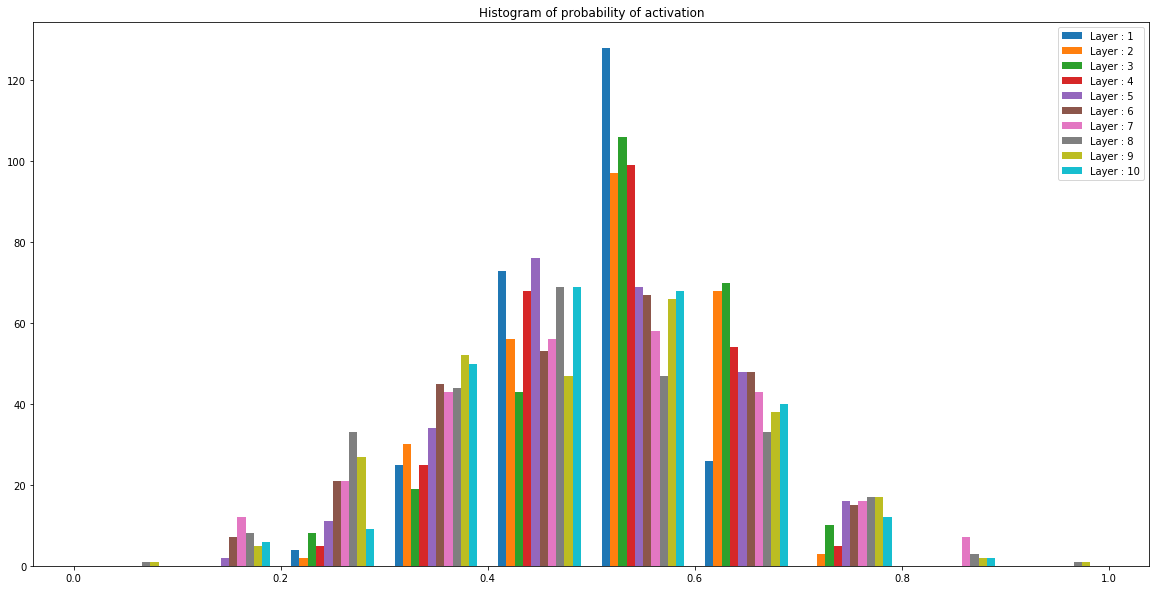

In [56]:
activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
activation_metrics()